In [14]:
import xarray as xr
import numpy as np
import matplotlib.pyplot
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import matplotlib.ticker as ticker
# spatial subscript
state_names = ['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delaware', 'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana', 'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland', 'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi', 'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire', 'New Jersey', 'New Mexico', 'New York', 'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon', 'Pennsylvania', 'Rhode Island', 'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont', 'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming', 'District of Columbia']

# non-spatial subscript
variant_list = ["Delta", 'Omicron', "BA5"]
vax_status_list = ['Vx', 'NVx']

state_lst_1=[]
state_lst_2=[]
state_lst_3=[]
state_lst_4=[]
state_lst_5=[]
state_lst_6=[]
for name in state_names:
    state_lst_1.append(f"Impact of Treatment on Fatality Rate[{name}]")
    state_lst_2.append(f"Base Fatality Rate for Unit Acuity[{name}]")
    state_lst_3.append(f"Reference Force of Infection[{name}]")
    state_lst_4.append(f"Strength of Adherence Fatigue[{name}]")
    state_lst_5.append(f"Variant Intro Start Time[{name}]")
    state_lst_6.append(f"Variant Intro Start Time2[{name}]")

param_lst_lst=[
    state_lst_1, # ['Impact of Treatment on Fatality Rate[Alabama]', 'Impact of Treatment on Fatality Rate[Alaska]' ...]
    state_lst_2,
    state_lst_3,
    state_lst_4,
    state_lst_5,
    state_lst_6,
    ['Extra Vaccine Impact on Responsiveness[Vx]'],
    ['Extra Vaccine Impact on Responsiveness[NVx]'],
    ['Extra Vaccine Impact on Responsiveness[Naive]'],
    ['Immunity Loss Time[Vx]'],
    ['Immunity Loss Time[NVx]'],
    ['Immunity Loss Time[Naive]'],
    ['Variant Accuity Multiplier[Omicron]'],
    ['Variant Accuity Multiplier[Delta]'],
    ['Variant Accuity Multiplier[BA5]'],
    ['Variant Impact on Immunity Loss Time[Omicron]'],
    ['Variant Impact on Immunity Loss Time[Delta]'],
    ['Variant Impact on Immunity Loss Time[BA5]'],
    ['Variant Intro Start Time3'],
    ['Variant Transmission Multiplier[Omicron]'],
    ['Variant Transmission Multiplier[Delta]'],
    ['Variant Transmission Multiplier[BA5]']
]

vv_param_names=['Variant Impact on Immunity Loss Time[Omicron]',
 'Variant Impact on Immunity Loss Time[Delta]',
 'Variant Impact on Immunity Loss Time[BA5]',
 'Impact of Treatment on Fatality Rate',
 'Base Fatality Rate for Unit Acuity',
 'Reference Force of Infection',
 'Strength of Adherence Fatigue',
 'Variant Intro Start Time',
 'Variant Intro Start Time2',
 'Extra Vaccine Impact on Responsiveness[Vx]',
 'Extra Vaccine Impact on Responsiveness[NVx]',
 'Extra Vaccine Impact on Responsiveness[Naive]',
 'Immunity Loss Time[Vx]',
 'Immunity Loss Time[NVx]',
 'Immunity Loss Time[Naive]',
 'Variant Accuity Multiplier[Omicron]',
 'Variant Accuity Multiplier[Delta]',
 'Variant Accuity Multiplier[BA5]',
 'Variant Intro Start Time3',
 'Variant Transmission Multiplier[Omicron]',
 'Variant Transmission Multiplier[Delta]',
 'Variant Transmission Multiplier[BA5]']


## 1. Define xarray structure to store elasticity
xarray is a labeled multidimensional data structure with `dims`,`coords` (value of `dims`), `data_vars`. Greatest benefit for spatio-temportal sensitivity using this structure is a function `.sum()`. With this command exemplified below, we can add along specificed axis (e.g. `component` (death, gdp, hospitalization), `space` (51 states)).

In [15]:
dv = {
    "coords": {
        'value': {"dims": ("value"), "data": ["marginal", "average"]},
        'component': {"dims": ("component"),  "data": ['death', 'gdp', 'hospitalization']},
        'params': {"dims": ("params"), "data": [param for param in vv_param_names]},
        'space': {"dims" : ("space"), "data": state_names}
    },
    "dims": {"value", "component", "params"},
    "data_vars":{ #5+ 3
        'VV_csv': {"dims": ("component","space", "value"), "data": np.zeros(shape = (3, len(state_names), 2))},
        'VV_cv': {"dims": ("component", "value"), "data": np.zeros(shape = (3, 2))},
        'VV_sv': {"dims": ("space", "value"), "data": np.zeros(shape = (len(state_names), 2))},
        'VV_v': {"dims": ("value"), "data": np.zeros(shape = (2))},

        'VV_1_pcsv': {"dims": ("params", "component", "space", "value"), "data": np.zeros(shape = (len(vv_param_names),3,len(state_names), 2))},
        'VV_1_pcv': {"dims": ("params", "component", "value"), "data": np.zeros(shape = (len(vv_param_names),3, 2))},
        'VV_1_pv': {"dims": ("params", "value"), "data": np.zeros(shape = (len(vv_param_names), 2))},

        'epsilon_pv': {"dims": ("params", "value"), "data": np.zeros(shape = (len(vv_param_names), 2))},
        'epsilon_pcv': {"dims": ("params", "component", "value"), "data": np.zeros(shape = (len(vv_param_names), 3, 2))},
    },
   "attrs": {"title": "vaccine value disaggregated by parameter, time, space, component"}
    }
vds = xr.Dataset.from_dict(dv)
vds

<xarray.Dataset>
Dimensions:      (value: 2, component: 3, params: 22, space: 51)
Coordinates:
  * value        (value) <U8 'marginal' 'average'
  * component    (component) <U15 'death' 'gdp' 'hospitalization'
  * params       (params) <U45 'Variant Impact on Immunity Loss Time[Omicron]...
  * space        (space) <U20 'Alabama' 'Alaska' ... 'District of Columbia'
Data variables:
    VV_csv       (component, space, value) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VV_cv        (component, value) float64 0.0 0.0 0.0 0.0 0.0 0.0
    VV_sv        (space, value) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    VV_v         (value) float64 0.0 0.0
    VV_1_pcsv    (params, component, space, value) float64 0.0 0.0 ... 0.0 0.0
    VV_1_pcv     (params, component, value) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    VV_1_pv      (params, value) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    epsilon_pv   (params, value) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    epsilon_pcv  (params, component, value) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:    vaccine value disaggregated by parameter, time, space, component

In [18]:
vds.sel(dict(component = 'death', space='Alabama', value = 'marginal')).values()

ValuesView(<xarray.Dataset>
Dimensions:      (params: 22)
Coordinates:
    value        <U8 'marginal'
    component    <U15 'death'
  * params       (params) <U45 'Variant Impact on Immunity Loss Time[Omicron]...
    space        <U20 'Alabama'
Data variables:
    VV_csv       float64 0.0
    VV_cv        float64 0.0
    VV_sv        float64 0.0
    VV_v         float64 0.0
    VV_1_pcsv    (params) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    VV_1_pcv     (params) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    VV_1_pv      (params) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    epsilon_pv   (params) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    epsilon_pcv  (params) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
Attributes:
    title:    vaccine value disaggregated by parameter, time, space, component)

In [19]:
df.sel(dict(component = 'hospitalization', space='Texas', value = 'marginal')).values()

NameError: name 'df' is not defined

## 2. store vensim values into xarray

In [ ]:
#51 states * 4 (efficacy of  death, gdp, health, population)
# row 0, 4-54 (csv's 6-56) -> 1 set, death
# row 1,55 -105 (csv's 57-107)-> 2 set, gdp
# row 2, 106-156(csv's 108-158) -> 3 set, hosp

# BASELINE HAPPENS ONCE
avg = pd.read_csv("avg_cost_per_person_base.tsv", sep="\t", index_col=0)
marg = pd.read_csv("marg_cost_per_person_base.tsv", sep="\t", index_col=0)
vds['VV_csv'].loc[dict(component = 'death', value = 'average')] = avg.loc[4:54].values.flatten()
vds['VV_csv'].loc[dict(component = 'gdp', value = 'average')] = avg.loc[55:105].values.flatten()
vds['VV_csv'].loc[dict(component = 'hospitalization',value= 'average')] = avg.loc[106:156].values.flatten()

vds['VV_csv'].loc[dict(component = 'death', value = 'marginal')] = marg.loc[4:54].values.flatten()
vds['VV_csv'].loc[dict(component = 'gdp', value = 'marginal')] = marg.loc[55:105].values.flatten()
vds['VV_csv'].loc[dict(component ='hospitalization', value ='marginal')] = marg.loc[106:156].values.flatten()


vds['VV_cv'].loc[dict(component = 'death', value = 'average')] = avg.loc[0].values.item()
vds['VV_cv'].loc[dict(component = 'gdp', value = 'average')] = avg.loc[1].values.item()
vds['VV_cv'].loc[dict(component = 'hospitalization',value= 'average')] = avg.loc[2].values.item()

vds['VV_cv'].loc[dict(component = 'death', value = 'marginal')] = marg.loc[0].values.item()
vds['VV_cv'].loc[dict(component = 'gdp', value = 'marginal')] = marg.loc[1].values.item()
vds['VV_cv'].loc[dict(component ='hospitalization', value ='marginal')] = marg.loc[2].values.item()

vds['VV_sv'] = vds['VV_csv'].sum(dim = 'component')
vds['VV_v'] = vds['VV_cv'].sum(dim = 'component')

# COUNTERFACTUAL HAPPENS 22 times
for file_param, param in zip(vv_param_names, vv_param_names):
    print(file_param)
    file = file_param.replace(" ", "_")
    print(file)
    avg=pd.read_csv(file +'_avg.tsv', sep='\t', index_col=0)
    marg=pd.read_csv(file+'_marg.tsv', sep='\t', index_col=0)
    print(avg)
    print(marg)

    vds['VV_1_pcsv'].loc[dict(params = param, component = 'death', value='average')] = avg.loc[4:54].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'gdp', value='average')] = avg.loc[55:105].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'hospitalization', value='average')] = avg.loc[106:156].values.flatten()

    vds['VV_1_pcsv'].loc[dict(params = param, component = 'death', value='marginal')] = marg.loc[4:54].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'gdp', value='marginal')] = marg.loc[55:105].values.flatten()
    vds['VV_1_pcsv'].loc[dict(params = param,component = 'hospitalization', value='marginal')] = marg.loc[106:156].values.flatten()

    vds['VV_1_pcv'].loc[dict(params = param, component = 'death', value='average')] = avg.loc[0].values.item()
    vds['VV_1_pcv'].loc[dict(params = param,component = 'gdp', value='average')] = avg.loc[1].values.item()
    vds['VV_1_pcv'].loc[dict(params = param,component = 'hospitalization', value='average')] = avg.loc[2].values.item()

    vds['VV_1_pcv'].loc[dict(params = param, component = 'death', value='marginal')] = marg.loc[0].values.item()
    vds['VV_1_pcv'].loc[dict(params = param,component = 'gdp', value='marginal')] = marg.loc[1].values.item()
    vds['VV_1_pcv'].loc[dict(params = param,component = 'hospitalization', value='marginal')] = marg.loc[2].values.item()

    vds['VV_1_pv'] = vds['VV_1_pcv'].sum(dim = 'component')

vds

Variant Impact on Immunity Loss Time[Omicron]
Variant_Impact_on_Immunity_Loss_Time[Omicron]
            0
0   -0.257579
1   -0.228044
2   -0.214592
3   -0.255473
4   -0.138037
..        ...
203 -0.235128
204 -0.202591
205 -0.132371
206 -0.101861
207 -0.163436

[208 rows x 1 columns]
            0
0   -0.386754
1   -0.202840
2   -0.311042
3   -0.366402
4   -0.503778
..        ...
203 -0.419896
204 -0.251465
205 -0.348542
206 -0.198660
207 -0.186697

[208 rows x 1 columns]
Variant Impact on Immunity Loss Time[Delta]
Variant_Impact_on_Immunity_Loss_Time[Delta]
            0
0   -0.458634
1   -0.206116
2   -0.175895
3   -0.440871
4   -0.345093
..        ...
203 -0.442428
204 -0.309644
205 -0.310406
206 -0.220215
207 -0.258530

[208 rows x 1 columns]
            0
0   -0.604303
1   -0.000000
2   -0.311042
3   -0.536821
4   -1.007557
..        ...
203 -0.423852
204 -0.237424
205  0.012806
206 -0.282838
207 -0.015275

[208 rows x 1 columns]
Variant Impact on Immunity Loss Time[BA5]
Variant_Im

<xarray.Dataset>
Dimensions:      (value: 2, component: 3, params: 22, space: 51)
Coordinates:
  * value        (value) <U8 'marginal' 'average'
  * component    (component) <U15 'death' 'gdp' 'hospitalization'
  * params       (params) <U45 'Variant Impact on Immunity Loss Time[Omicron]...
  * space        (space) <U20 'Alabama' 'Alaska' ... 'District of Columbia'
Data variables:
    VV_csv       (component, space, value) float64 -1.263e+04 ... -49.32
    VV_cv        (component, value) float64 -1.597e+04 -3.655e+04 ... -109.8
    VV_sv        (space, value) float64 -1.381e+04 -2.725e+04 ... -3.239e+04
    VV_v         (value) float64 -1.812e+04 -3.93e+04
    VV_1_pcsv    (params, component, space, value) float64 -0.5038 ... -0.0
    VV_1_pcv     (params, component, value) float64 -0.3868 -0.2576 ... -0.0
    VV_1_pv      (params, value) float64 -0.9006 -0.7002 -0.9153 ... 0.0 0.0
    epsilon_pv   (params, value) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    epsilon_pcv  (params, component, value) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:    vaccine value disaggregated by parameter, time, space, component

Average and marginal value of vaccine is stored in vds['VV_1_pv'] whose gap with vds['VV_v'] is divided by vds['VV_v']. Then this sensitivity of marginal vaccine value is divided by 0.01 (which is how much we increased each parameter).

## 3. plot and store

In [ ]:
vds['VV_v'].loc[dict(value='average')]

<xarray.DataArray 'VV_v' ()>
array(-39298.391394)
Coordinates:
    value    <U8 'average'

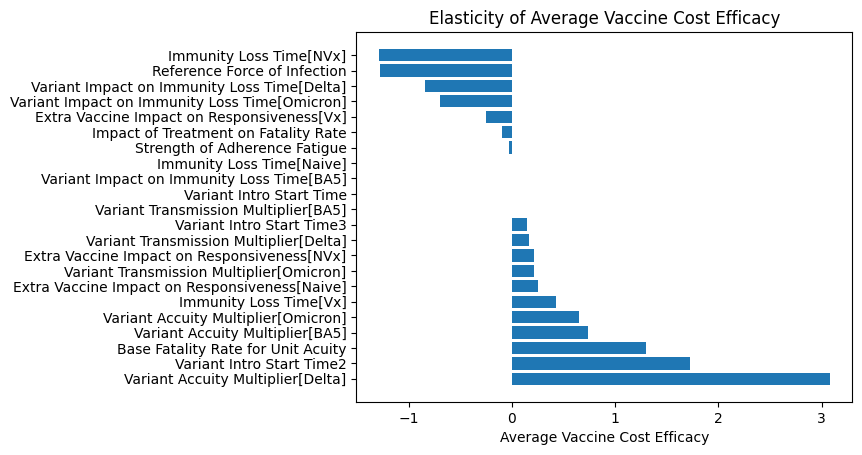

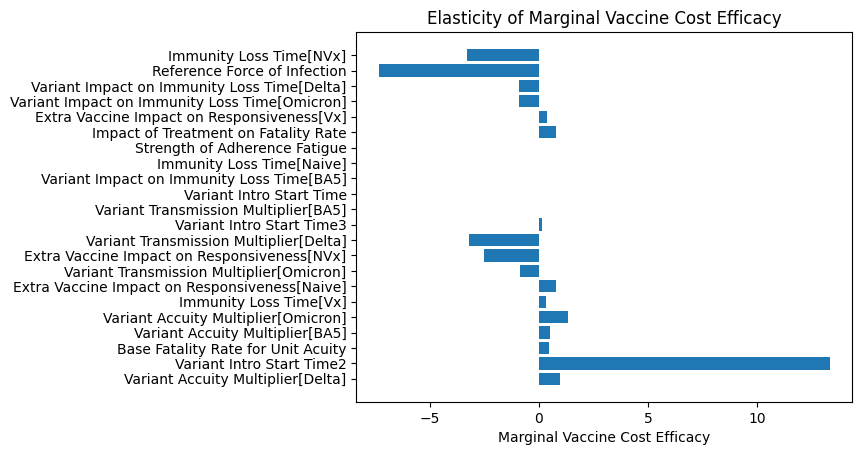

In [ ]:
def plot_sensitivity(vds):
    matplotlib.pyplot.rcdefaults()
    fig_avg, ax_avg = matplotlib.pyplot.subplots()
    fig_marg, ax_marg = matplotlib.pyplot.subplots()

    x_avg=[avg for marg, avg in vds['VV_1_pv'].values]
    x_marg=[marg for marg, avg in vds['VV_1_pv'].values]
    x_label=[val for val in vds.params.values]
    y_vars=[x for x in range(len(vds['VV_1_pv']))]
    x_avg_sorted=[]
    x_marg_sorted=[]
    x_label_sorted=[]
    for avg, marg, label in sorted(zip(x_avg, x_marg, x_label)):
        x_avg_sorted.append(avg)
        x_marg_sorted.append(marg)
        x_label_sorted.append(label)

    ax_avg.barh(x_label_sorted, x_avg_sorted, align='center')
    ax_avg.set_yticks(y_vars)
    ax_avg.invert_yaxis()  # labels read top-to-bottom
    ax_avg.set_xlabel('Average Vaccine Cost Efficacy')
    ax_avg.set_title('Elasticity of Average Vaccine Cost Efficacy')

    ax_marg.barh(x_label_sorted, x_marg_sorted, align='center')
    ax_marg.set_yticks(y_vars)
    ax_marg.invert_yaxis()  # labels read top-to-bottom
    ax_marg.set_xlabel('Marginal Vaccine Cost Efficacy')
    ax_marg.set_title('Elasticity of Marginal Vaccine Cost Efficacy')

    matplotlib.pyplot.show()
    return

plot_sensitivity(vds)

In [ ]:
vds.to_netcdf("vaccine_cost_efficiency_elasticity.nc")

ValueError: cannot read or write netCDF files without netCDF4-python or scipy installed

## 4. Comparison plot for parameter estimation validation

In [ ]:
df=pd.read_csv("Sim_DataAgg.csv", index_col=[0,1]).transpose()
df.columns.set_levels(['Sim', 'Data'], level = 0, inplace = True)
df.set_index(pd.date_range(start = '10/15/2019', periods = 1071), inplace=True)
df.columns.set_names(["sim_data", "component"], inplace=True)

test_fit_dict = {
    "coords": {
        'sim_data': {"dims": ("sim_data"), "data": ["sim", "data"]},
        'component': {"dims": ("component"),  "data": ['infection', 'death', 'hospitalization']},
        'time': {"dims": ("time"), "data": df.index},
        #'space': {"dims" : ("space"), "data": state_names} didn't implement space disaggregation for sim_data comparison yet
    },
    "dims": {"sim_data", "component", "time"},
    "data_vars":{ # 3 * 2
        'population': {"dims": ("sim_data","component", "time"), "data": np.zeros(shape = (2, 3, len(df.index)))},
    },
   "attrs": {"title": "population of infected, died, tested for data and simulated (conditional on estimated parameter)"}
    }
test_fit_xr = xr.Dataset.from_dict(test_fit_dict)
test_fit_xr

/var/folders/9z/bf6qfjvd695cjkj7s4ss1cxh0000gn/T/ipykernel_95601/3555423592.py:2: FutureWarning: inplace is deprecated and will be removed in a future version.
  df.columns.set_levels(['Sim', 'Data'], level = 0, inplace = True)


<xarray.Dataset>
Dimensions:     (sim_data: 2, component: 3, time: 1071)
Coordinates:
  * sim_data    (sim_data) <U4 'sim' 'data'
  * component   (component) <U15 'infection' 'death' 'hospitalization'
  * time        (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19
Data variables:
    population  (sim_data, component, time) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
Attributes:
    title:    population of infected, died, tested for data and simulated (co...

In [ ]:
test_fit_xr['population'].loc[dict(sim_data = 'sim', component = 'infection')] =  df.loc[:, ('Sim', 'Infection')]
test_fit_xr['population'].loc[dict(sim_data = 'sim', component = 'hospitalization')] =  df.loc[:, ('Sim', 'Test')]
test_fit_xr['population'].loc[dict(sim_data = 'sim', component = 'death')] =  df.loc[:, ('Sim', 'Death')]
test_fit_xr['population'].loc[dict(sim_data = 'data', component = 'infection')] =  df.loc[:, ('Data', 'Infection')]
test_fit_xr['population'].loc[dict(sim_data = 'data', component = 'hospitalization')] =  df.loc[:, ('Data', 'Test')]
test_fit_xr['population'].loc[dict(sim_data = 'data', component = 'death')] =  df.loc[:, ('Data', 'Death')]
test_fit_xr

<xarray.Dataset>
Dimensions:     (sim_data: 2, component: 3, time: 1071)
Coordinates:
  * sim_data    (sim_data) <U4 'sim' 'data'
  * component   (component) <U15 'infection' 'death' 'hospitalization'
  * time        (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19
Data variables:
    population  (sim_data, component, time) float64 2.0 2.0 ... 4.769e+03
Attributes:
    title:    population of infected, died, tested for data and simulated (co...

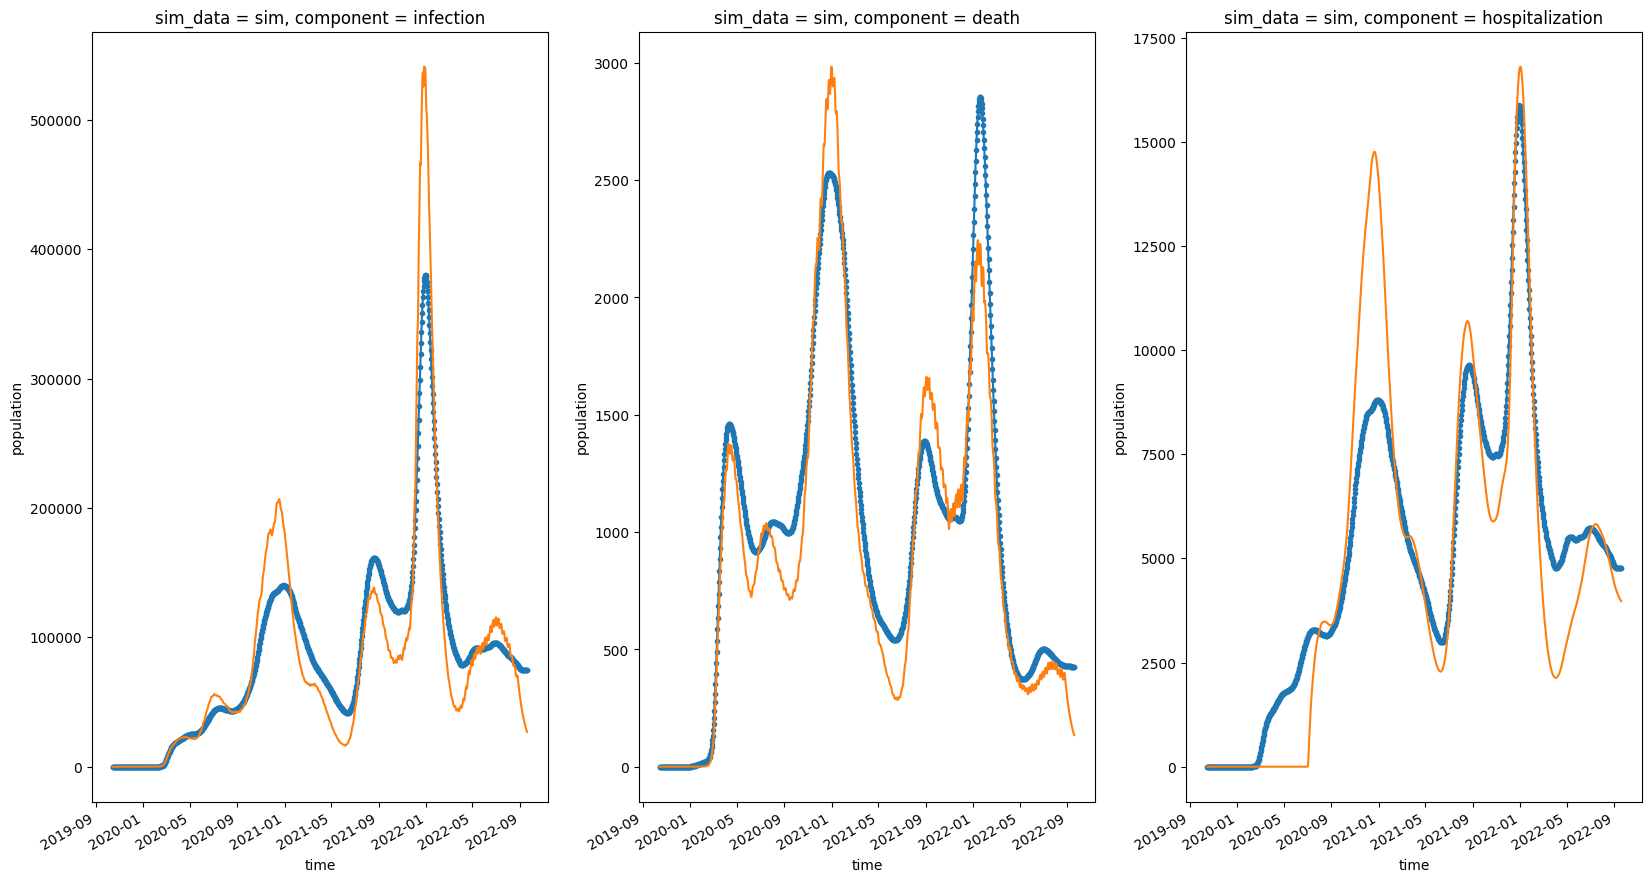

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for comp, ax in zip(test_fit_xr.component, axes):
    test_fit_xr.sel(dict(component = comp, sim_data='data'))['population'].plot.line(ax = ax, x = 'time', marker ='.', markersize = 6, add_legend = True)
    test_fit_xr.sel(dict(component = comp, sim_data='sim'))['population'].plot.line(ax = ax, x = 'time', add_legend = True)
    
    #plt.title(f"{comp} with blue as data and orange as simulated")


                   2019-12-31  2020-03-31  2020-06-30  2020-09-30  2020-12-31  \
state                                                                           
California (Data)   2780000.0   2740000.0   2500000.0   2690000.0   2730000.0   
New York (Data)     1500000.0   1480000.0   1340000.0   1430000.0   1440000.0   
Texas (Data)        1820000.0   1780000.0   1640000.0   1750000.0   1770000.0   
California (Sim)    2770000.0   2740000.0   2550000.0   2680000.0   2740000.0   
New York (Sim)      1500000.0   1450000.0   1340000.0   1430000.0   1470000.0   
Texas (Sim)         1810000.0   1740000.0   1650000.0   1740000.0   1780000.0   

                   2021-03-31  2021-06-30  2021-09-30  2021-12-31  
state                                                              
California (Data)   2800000.0   2860000.0   2880000.0   2950000.0  
New York (Data)     1460000.0   1490000.0   1500000.0   1520000.0  
Texas (Data)        1790000.0   1820000.0   1840000.0   1880000.0  
California 

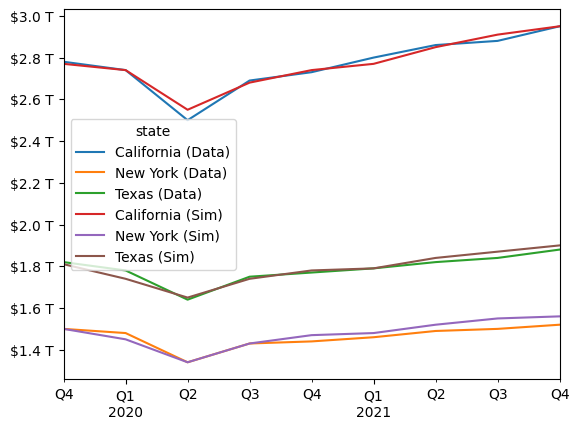

In [ ]:
import pandas
import datetime
results=pd.read_csv("Covidtime_series.csv", index_col=["Time", "Unnamed: 1", "Unnamed: 2" ])

# print(results)

# deaths_data=results.loc["Data Cumulative Deaths of Confirmed"]
# deaths_data.dropna(inplace=True, how="all", axis=1)
# deaths_sim=results.loc["Cumulative Deaths of Confirmed"]

# deaths_sim.index.rename(inplace=True, names=["state", "empty"])
# deaths_sim=deaths_sim.groupby(level=[0]).sum()
# print(deaths_sim)

# deaths_full=deaths_data.loc[["California", "New York", "Texas"]]
# deaths_full.rename(index={
#     "California":"California (Data)",
#     "Texas":"Texas (Data)",
#     "New York":"New York (Data)"
# },inplace=True)
#print(deaths_full)
# deaths_full=pd.concat([deaths_full, deaths_sim.loc[["California", "New York", "Texas"], deaths_data.columns]])
# deaths_full.rename(index={
#     "California":"California (Sim)",
#     "Texas":"Texas (Sim)",
#     "New York":"New York (Sim)"
# },inplace=True)
# deaths_full.T.plot()
# # plt.pyplot.show()

# print(deaths_data)
#print(deaths_sim.loc[:, deaths_data.columns])


gdp_data=results.loc['Real World GDP Data (Gt)""']
gdp_data.dropna(inplace=True, how="all", axis=1)
gdp_data.index.rename(inplace=True, names=["state", "empty"])
gdp_data=gdp_data.droplevel("empty")
gdp_sim=results.loc["Reported Cumulated GDP"]
gdp_sim.dropna(inplace=True, how="all", axis=1)
gdp_sim.index.rename(inplace=True, names=["state", "empty"])
gdp_sim=gdp_sim.droplevel("empty")
gdp_full=gdp_data.loc[["California", "New York", "Texas"]]
gdp_full.rename(index={
    "California":"California (Data)",
    "Texas":"Texas (Data)",
    "New York":"New York (Data)"
},inplace=True)
gdp_full=pandas.concat([gdp_full, gdp_sim.loc[["California", "New York", "Texas"]]])
gdp_full.columns = [datetime.timedelta(days=int(x)) + df.index[0] for x in gdp_full.columns]
gdp_full.rename(index={
    "California":"California (Sim)",
    "Texas":"Texas (Sim)",
    "New York":"New York (Sim)"
},inplace=True)

print(gdp_full)
ax = (gdp_full * 10**6/10**12).T.plot()

ax.yaxis.set_major_formatter('${x:1.2} T')
plt.show()

Time series marginal vaccine value

- MVV disaggregated by state and component (bar graph y axis: state)
- select final time decompose by 

In [47]:
vv_xr["VV_1_pcstv"].loc[{"value": "marginal", "params": "baseline", "space": f"{space}"}]

<xarray.DataArray 'VV_1_pcstv' (component: 3, time: 1071)>
[3213 values with dtype=float64]
Coordinates:
    value      <U8 'marginal'
  * component  (component) object 'death' 'gdp' 'hospitalization'
    params     <U8 'baseline'
    space      <U20 'District of Columbia'
  * time       (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19

In [64]:
vv_xr["VV_1_pcstv"].loc[{"value": "marginal", "params": "baseline",  "space": f"{space}"}]

<xarray.DataArray 'VV_1_pcstv' (component: 3, time: 1071)>
[3213 values with dtype=float64]
Coordinates:
    value      <U8 'marginal'
  * component  (component) object 'death' 'gdp' 'hospitalization'
    params     <U8 'baseline'
    space      <U7 'Alabama'
  * time       (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19

In [77]:
vv_xr["VV_1_pcstv"]

<xarray.DataArray 'VV_1_pcstv' (params: 1, component: 3, space: 51, value: 5,
                                time: 1071)>
[819315 values with dtype=float64]
Coordinates:
  * value      (value) object 'marginal' 'average' '1.01' '1' '0'
  * component  (component) object 'death' 'gdp' 'hospitalization'
  * params     (params) object 'baseline'
  * space      (space) object 'Alabama' 'Alaska' ... 'District of Columbia'
  * time       (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19

In [80]:
VV_1_pcstv = vv_xr["VV_1_pcstv"].loc[{"value": "marginal", "params": "baseline"}]
components = VV_1_pcstv.coords.keys()
components

KeysView(Coordinates:
    value      <U8 'marginal'
  * component  (component) object 'death' 'gdp' 'hospitalization'
    params     <U8 'baseline'
  * space      (space) object 'Alabama' 'Alaska' ... 'District of Columbia'
  * time       (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19)

In [84]:
components = VV_1_pcstv.coords.keys()
num_subplots = len(components)
num_subplots

5

In [85]:
VV_1_pcstv

<xarray.DataArray 'VV_1_pcstv' (component: 3, space: 51, time: 1071)>
[163863 values with dtype=float64]
Coordinates:
    value      <U8 'marginal'
  * component  (component) object 'death' 'gdp' 'hospitalization'
    params     <U8 'baseline'
  * space      (space) object 'Alabama' 'Alaska' ... 'District of Columbia'
  * time       (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19

In [20]:
df["VV_1_pctv"].loc[{"value": "marginal", "params": "baseline"}].values #all zero
df["VV_1_pcstv"].loc[{"value": "marginal", "params": "baseline"}].values #nonzero

array([[[   0.        ,    0.        ,    0.        , ...,
         -583.99548185, -584.0837118 , -584.17194175],
        [   0.        ,    0.        ,    0.        , ...,
         -307.40104449, -307.71779564, -308.03643216],
        [   0.        ,    0.        ,    0.        , ...,
         -602.25146555, -602.51862757, -602.60648686],
        ...,
        [   0.        ,    0.        ,    0.        , ...,
         -293.05023731, -293.21766143, -293.38508556],
        [   0.        ,    0.        ,    0.        , ...,
         -424.69068665, -424.85462578, -425.07637157],
        [   0.        ,    0.        ,    0.        , ...,
          293.37602943,  293.17581722,  293.04149026]],

       [[   0.        ,    0.        ,    0.        , ...,
          -97.62476524,  -97.67392192,  -97.75458479],
        [   0.        ,    0.        ,    0.        , ...,
         -132.66735406, -132.73051489, -132.79367572],
        [   0.        ,    0.        ,    0.        , ...,
          -93.

In [88]:
vv_xr

<xarray.Dataset>
Dimensions:        (value: 5, component: 3, params: 1, space: 51, time: 1071)
Coordinates:
  * value          (value) object 'marginal' 'average' '1.01' '1' '0'
  * component      (component) object 'death' 'gdp' 'hospitalization'
  * params         (params) object 'baseline'
  * space          (space) object 'Alabama' 'Alaska' ... 'District of Columbia'
  * time           (time) datetime64[ns] 2019-10-15 2019-10-16 ... 2022-09-19
Data variables:
    VV_1_pcstv     (params, component, space, value, time) float64 ...
    VV_1_pctv      (params, component, value, time) float64 ...
    VV_1_ptv       (params, value, time) float64 ...
    epsilon_ptv    (params, value, time) float64 ...
    epsilon_pctv   (params, component, value, time) float64 ...
    epsilon_pcstv  (params, component, space, value, time) float64 ...
    VV_1_pstv      (params, space, value, time) float64 ...
Attributes:
    title:    vaccine value disaggregated by parameter, time, space, component

0
New York
1
California
2
Massachusetts
3
Texas


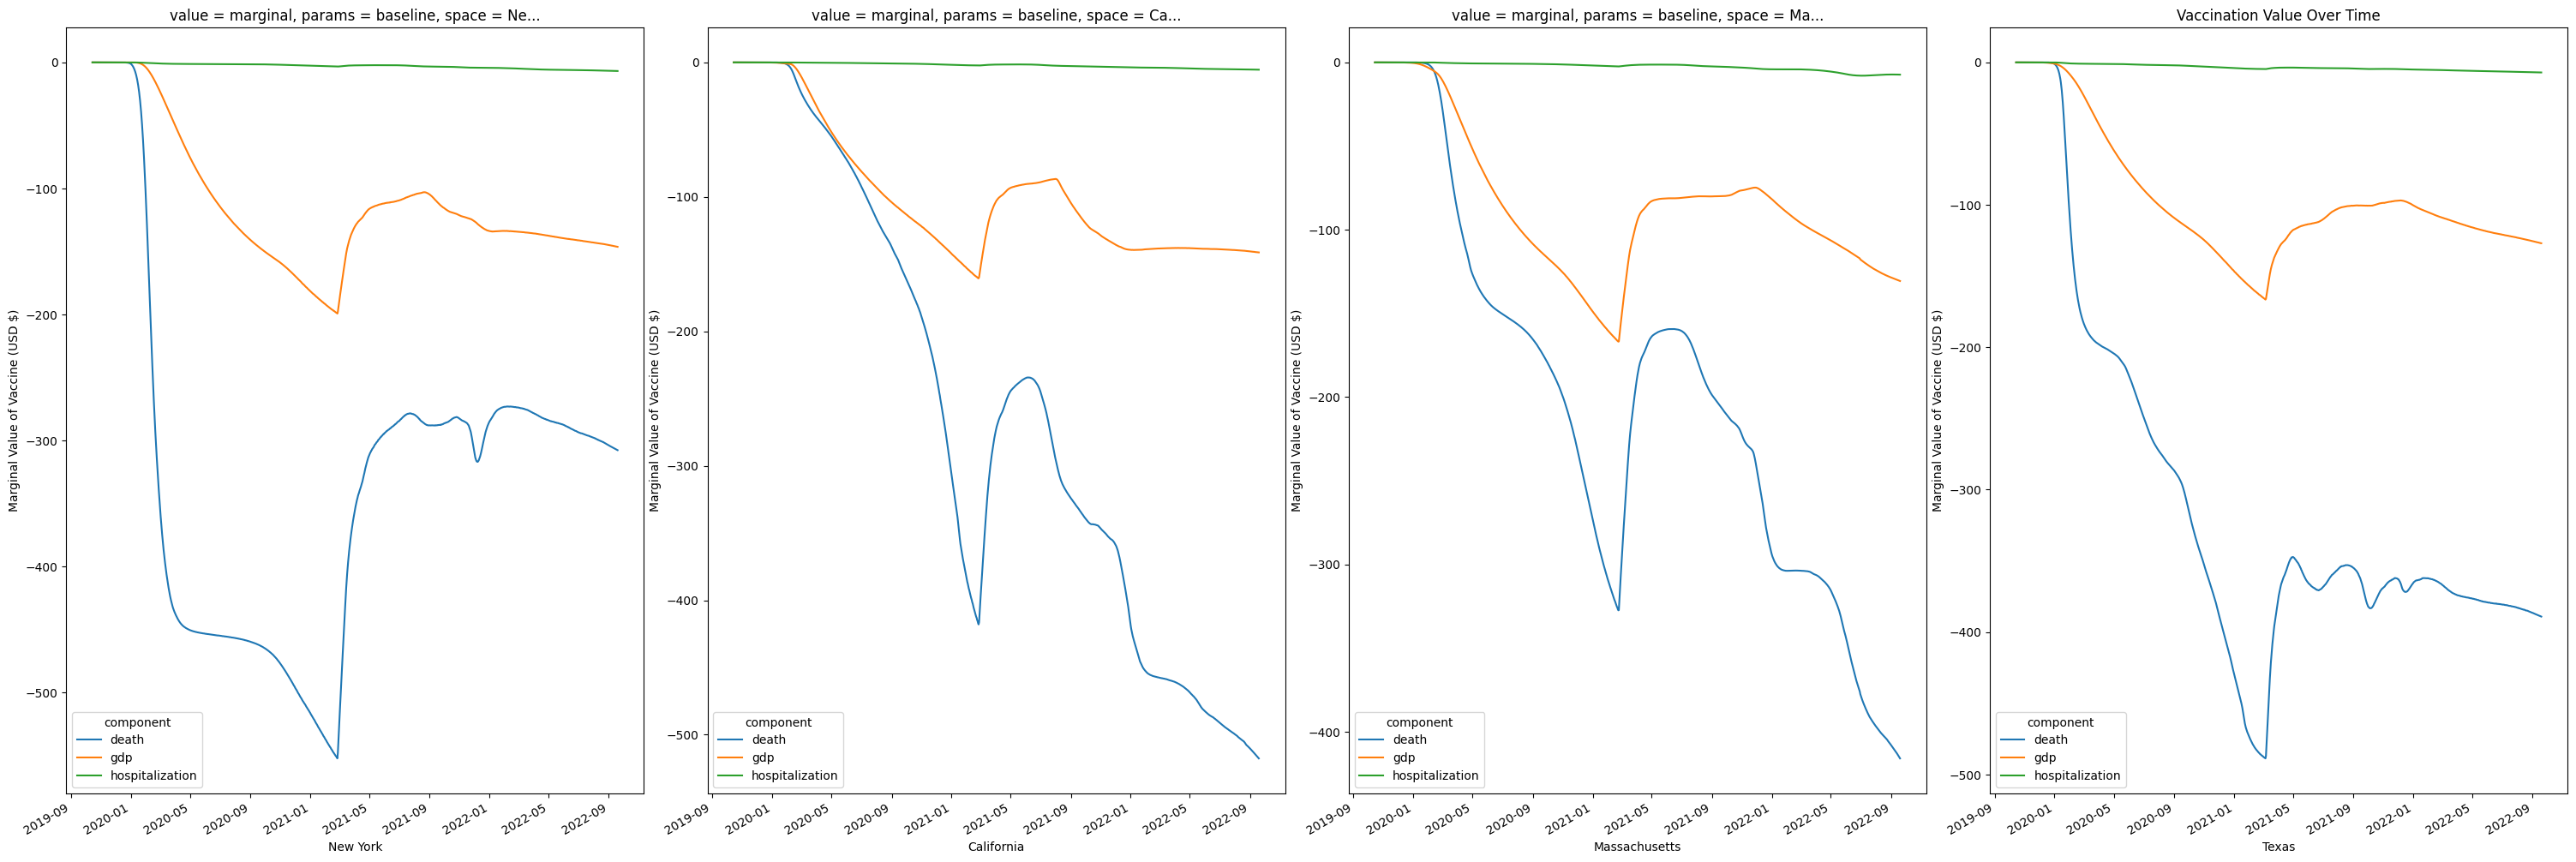

In [105]:
#marginal value of vaccine change over time, 
vv_xr = xr.open_dataset("../nc_data/vv_pcstv.nc")
bigstate = ["New York", "California", "Massachusetts", "Texas"]
fig, axes = plt.subplots(1, 4, figsize = (30,10))
for i, space in enumerate(bigstate):
    vv_xr["VV_1_pcstv"].loc[{"value": "marginal", "params": "baseline", "space": f'{space}'}].plot.line(ax = axes[i], x="time")
    plt.title("Vaccination Value Over Time")
    axes[i].set_ylabel("Marginal Value of Vaccine (USD $)")
    axes[i].axes.set_xlabel(f"{space}")
fig.tight_layout(pad=0.5)


In [ ]:
#marginal value of vaccine change over time, 
vv_xr = xr.open_dataset("../nc_data/vv_pcstv.nc")
bigstate = ["New York", "California", "Massachusetts", "Texas"]
fig, axes = plt.subplots(1, 4, figsize = (30,10))
for i, space in enumerate(bigstate):
    vv_xr["VV_1_pcstv"].loc[{"value": "marginal", "params": "baseline", "space": f'{space}'}].plot.line(ax = axes[i], x="time")
    plt.title("Vaccination Value Over Time")
    axes[i].set_ylabel("Marginal Value of Vaccine (USD $)")
    axes[i].axes.set_xlabel(f"{space}")
fig.tight_layout(pad=0.5)


<xarray.DataArray 'component' ()>
array('death', dtype='<U5')
Coordinates:
    component  <U5 'death'
<xarray.DataArray 'component' ()>
array('gdp', dtype='<U3')
Coordinates:
    component  <U3 'gdp'
<xarray.DataArray 'component' ()>
array('hospitalization', dtype='<U15')
Coordinates:
    component  <U15 'hospitalization'


Text(0.5, 1.0, 'Final Vaccine Value per State')

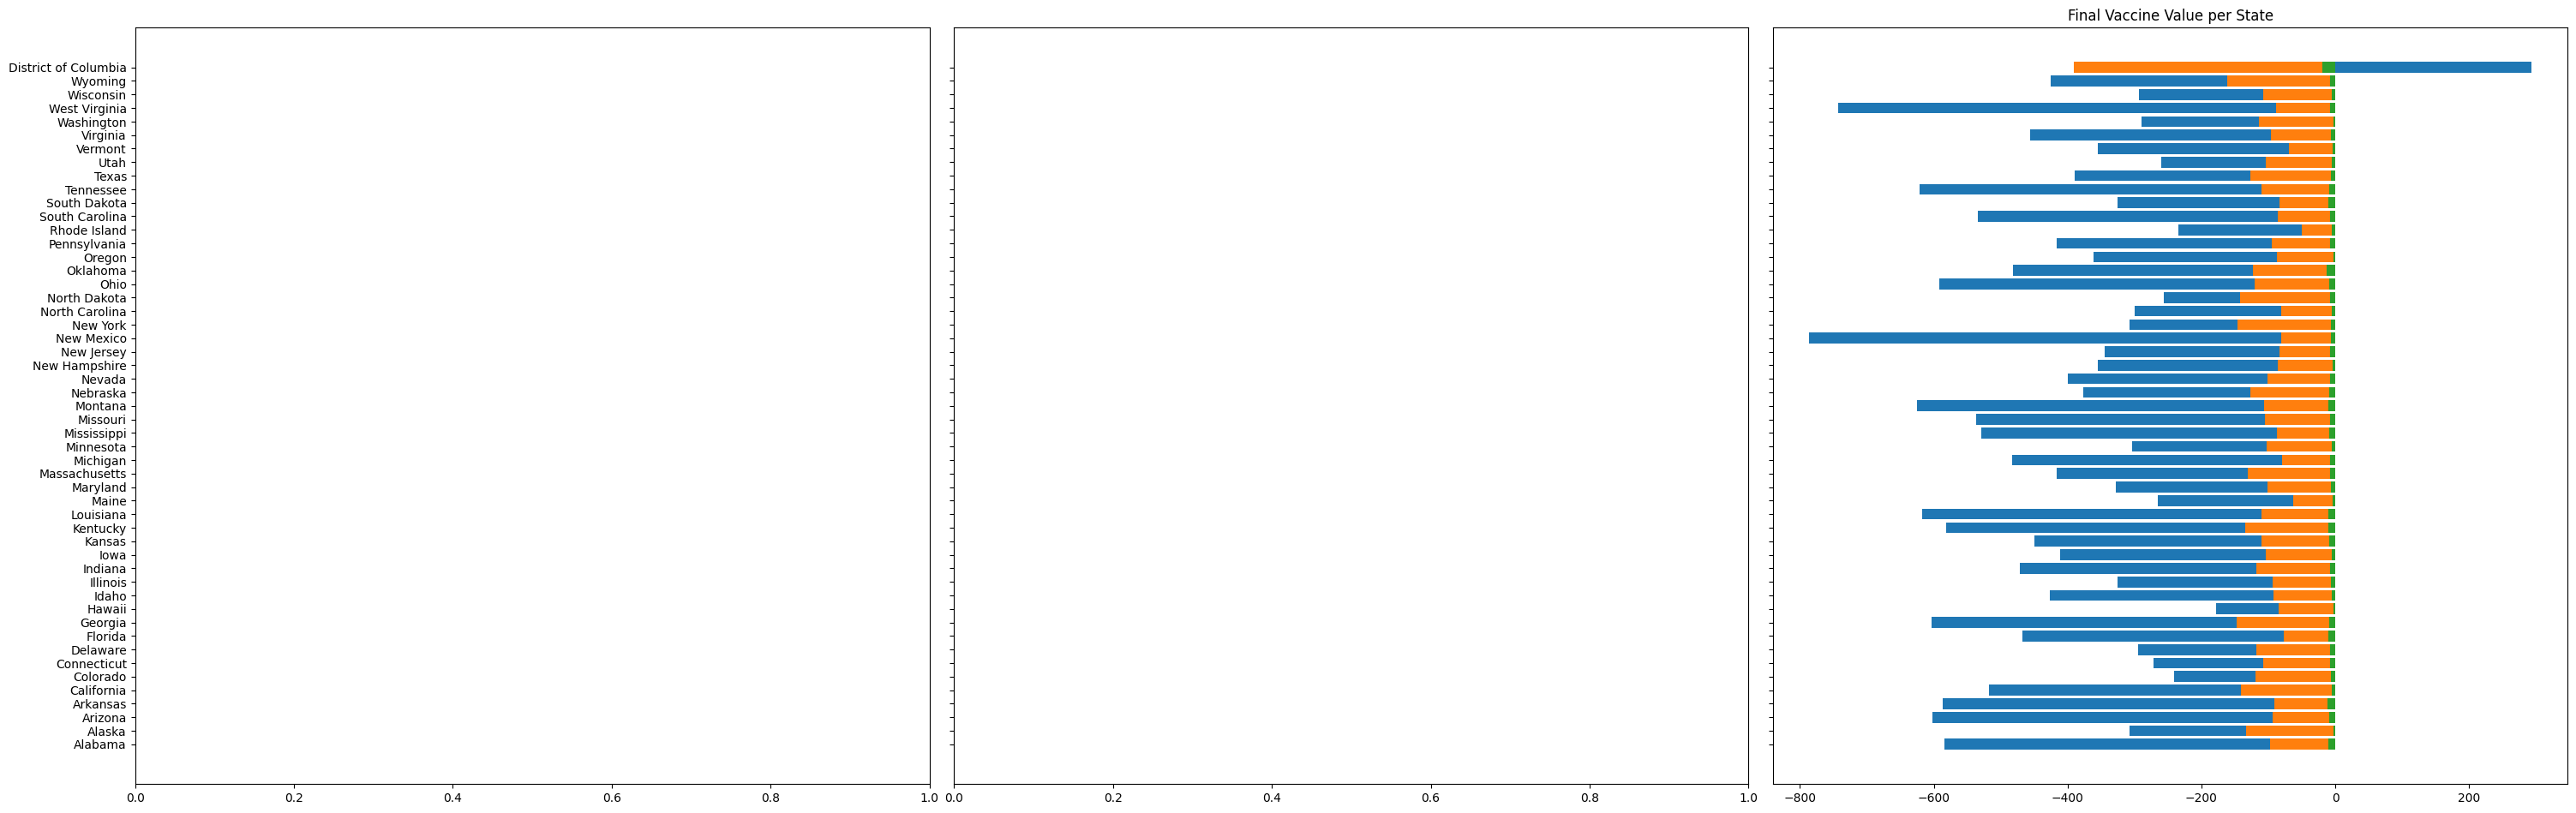

In [114]:
fig, axes = plt.subplots(1,3, sharey=True, figsize = (30,20))
for index, component in enumerate(df["component"]):
    print(component)
    axes[index]=plt.barh(
        df["space"],
        df["VV_1_pcstv"].loc[
            {"value": "marginal", "params": "baseline", "time": df["time"][-1], "component": component}
        ].values
    )
    axes[index].set_label(component)
fig.tight_layout(pad=0.5)
fig.set_figheight(9)
plt.title("Final Vaccine Value per State")